<a href="https://colab.research.google.com/github/ejihoon6065/Project_TurnAround/blob/master/SARIMA_1YEAR_TO_1YEAR_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set() # setting seaborn default for plots
import matplotlib.font_manager as fm
import copy
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
import numpy as np


from scipy import stats  # Box-Cox 검정
import statsmodels.api as sm  # qqplot
from statsmodels.tsa.stattools import adfuller    # adfuller : ADF그래프 그려주는 함수
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from statsmodels.stats.diagnostic import acorr_ljungbox # Ljung-Box 검정

import warnings
warnings.filterwarnings("ignore")

import itertools


# 돌리기전에, https://colab.research.google.com/drive/1oBXX3k3OOjdivwlDhpLmAqfq5B5dzFR1#scrollTo=AbTlhWommsXE 에 있는 코드도 참고 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# 현재 설정되어 있는 폰트 사이즈와 글꼴을 알아보자    ( https://colab.research.google.com/github/nicewook/datascience_exercise/blob/master/korean_font_on_matplotlib.ipynb#scrollTo=nzZ6wGntXBrP 참고)
!python --version
def current_font():
  print(f"설정 폰트 글꼴: {plt.rcParams['font.family']}, 설정 폰트 사이즈: {plt.rcParams['font.size']}")  # 파이썬 3.6 이상 사용가능하다
        
current_font()

# 그래프에서 한글깨짐방지를 위한 한글폰트(나눔폰트) 설치 및 설정과정

!apt-get update -qq                    # 나눔폰트(한글) 설치
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()

Python 3.6.9
설정 폰트 글꼴: ['sans-serif'], 설정 폰트 사이즈: 10.0
Selecting previously unselected package fonts-nanum.
(Reading database ... 144676 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
NanumGo

In [3]:
!pip install -U pykrx  # KRX데이터를 크롤링하기 위한 라이브러리설치

     |████████████████████████████████| 40kB 1.9MB/s 
     |████████████████████████████████| 61kB 3.5MB/s 
     |████████████████████████████████| 235kB 11.6MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 주가 크롤링

from pykrx import stock
df = stock.get_market_ohlcv_by_date("20180701", "20200831", "122870") # DataFrame, (시작날짜,종료날짜,종목번호)
df

와이지엔터테인먼트,시가,고가,저가,종가,거래량
날짜,,,,,
2018-07-02,36200,37450,35550,35950,416807
2018-07-03,36850,38200,36200,38100,689792
2018-07-04,38050,38700,37350,37800,305088
2018-07-05,37800,38000,36200,36850,267248
2018-07-06,36650,37500,36350,37450,261478
...,...,...,...,...,...
2020-08-25,47200,49350,47000,48700,397671
2020-08-26,48750,50800,48100,50400,586564
2020-08-27,49950,51400,49450,50900,528784


In [29]:
# train,test 데이터 나누기

train = df[:'2019-07-01']                   # 2018-07-02 ~ 2019-07-01 (약 1년) 
#test=df['2019-07-01':]                      # 2020-08-01 ~ 2020-08-31 (약 1개월)  


# column들 중, 종가만 고려한다
train.drop(['시가', '고가','저가','거래량'], axis='columns', inplace=True)
#test.drop(['시가', '고가','저가','거래량'], axis='columns', inplace=True)

In [30]:


# 각 데이터의 column=['시가', '고가', '저가', '종가', '거래량']

# Prophet모델에 input되기 위해서는 ['ds','y']로 column형식을 맞춰야 함

train['날짜']=train.index
#train=pd.DataFrame({'ds':train['날짜'],'y':train['종가']})
train=pd.DataFrame({'y':train['종가']})
#train=train.reset_index(drop=True)
train   # 

In [31]:
train

,y
날짜,
2018-07-02,35950
2018-07-03,38100
2018-07-04,37800
2018-07-05,36850
2018-07-06,37450
...,...
2019-06-25,28750
2019-06-26,28400
2019-06-27,29150


In [ ]:
test1 = df['2019-07-02':'2019-08-30']            
test2 = df['2019-09-02':'2019-10-31']          
test3 = df['2019-11-01':'2019-12-31']          
test4 = df['2020-01-02':'2020-02-29']           
test5 = df['2020-03-02':'2020-04-30']  
test_all=df['2019-07-02':'2020-04-30'] 


test1['날짜']=test1.index
test1_n=pd.DataFrame({'y':test1['종가']})
#test=test.reset_index(drop=True)

test2['날짜']=test2.index
test2_n=pd.DataFrame({'y':test2['종가']})
#test=test.reset_index(drop=True)

test3['날짜']=test3.index
test3_n=pd.DataFrame({'y':test3['종가']})
#test=test.reset_index(drop=True)

test4['날짜']=test4.index
test4_n=pd.DataFrame({'y':test4['종가']})
#test=test.reset_index(drop=True)

test5['날짜']=test5.index
test5_n=pd.DataFrame({'y':test5['종가']})
#test=test.reset_index(drop=True)

test_all['날짜']=test_all.index
test_all_n=pd.DataFrame({'y':test_all['종가']})
#test=test.reset_index(drop=True)

In [10]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True 

findfont: Font family ['NanumGothic Eco'] not found. Falling back to DejaVu Sans.


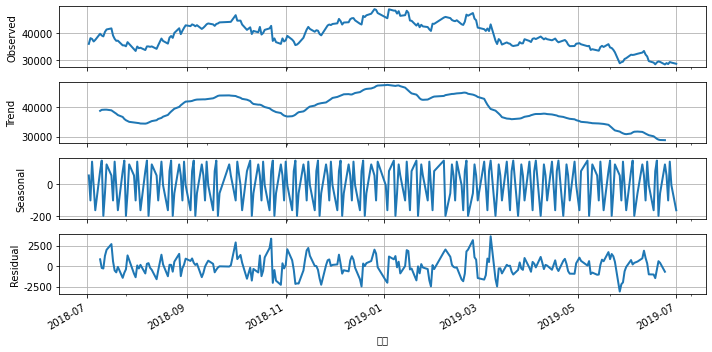

In [11]:
# 시계열분해

# 시계열데이터는 순서를 갖는 데이터, 즉 시간의 흐름에 따라 값이 변하는 데이터
# 시계열에는 경향(trend), 계절성(seasonality), 주기(cycle), 불규칙성(irregular) 성분이 있음.

result = seasonal_decompose(train.dropna(), model='additive',freq=10)   # freq = 10 (2-WEEKS )
result.plot()
plt.show()

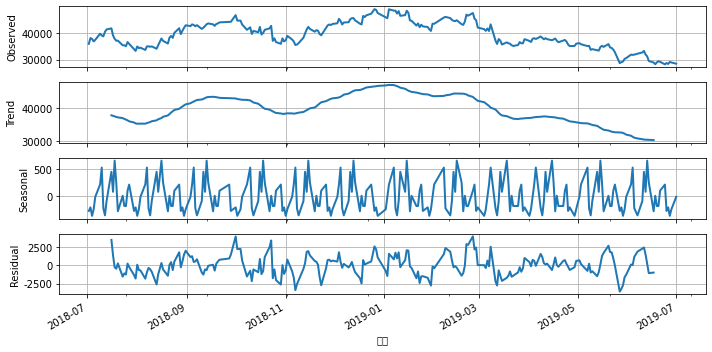

In [12]:
result = seasonal_decompose(train.dropna(), model='additive',freq=20)   # freq=20 (1-MONTH)
result.plot()
plt.show()

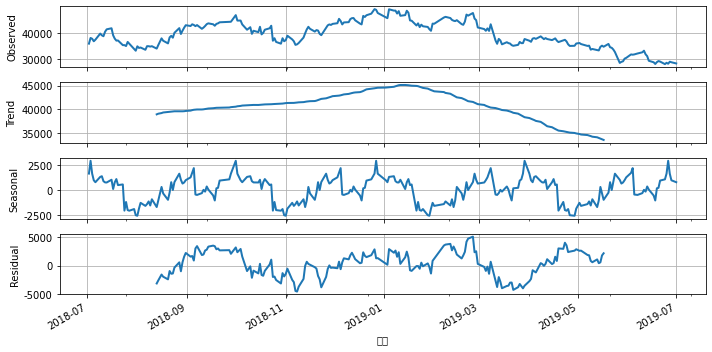

In [13]:
result = seasonal_decompose(train.dropna(), model='additive',freq=60)   # freq=60 (3-MONTH)    # 추세(trend)가 어느정도 보이고, 계절성(seasonal)도 뚜렷한 것을 볼수 있음.
result.plot()
plt.show()

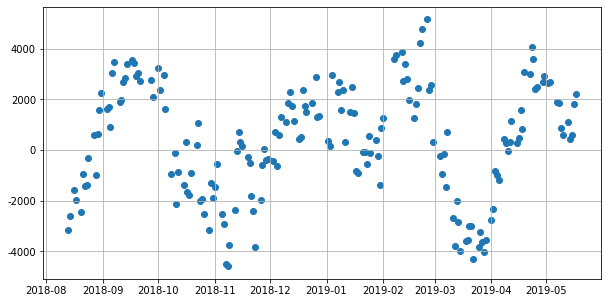

In [14]:
# 잔차분포 확인

residual=result.resid
residual=residual.dropna()

# 잔차 분포
plt.scatter(x=residual.index,y=residual)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-4590.85648148, -4395.94259259, -4201.0287037 , -4006.11481481,
        -3811.20092593, -3616.28703704, -3421.37314815, -3226.45925926,
        -3031.54537037, -2836.63148148, -2641.71759259, -2446.8037037 ,
        -2251.88981481, -2056.97592593, -1862.06203704, -1667.14814815,
        -1472.23425926, -1277.32037037, -1082.40648148,  -887.49259259,
         -692.5787037 ,  -497.66481481,  -302.75092593,  -107.83703704,
           87.07685185,   281.99074074,   476.90462963,   671.81851852,
          866.73240741,  1061.6462963 ,  1256.56018519,  1451.47407407,
         1646.38796296,  1841.30185185,  2036.21574074,  2231.12962963,
         2426.04351852,  2620.95740741,  2815.8712963 ,  3010.78518519,
         3205.69907407,  3400.6

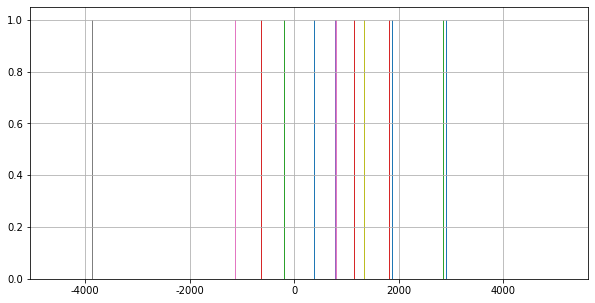

In [15]:
plt.hist(x=residual,bins=50)

In [18]:
# 정상성 확인함수 

# p-value가 0.05이하여야 정상성을 만족함  
# 그래프는 rollin_mean : 이동평균, rolling_std : 이동표준편차  
# 이동평균, 이동표준편차 : 정상성을 만족한다는 것은, 데이터의 평균과 분산이 일정하다는 의미이다. 
# 이동평균,이동표준편차 그래프를 통해서 평균과 표준편차가 x축과 평행인 선을 그리는지 알수 있기 때문에 그래프를 만들었음 
 
def get_stationarity(timeseries,wind_date):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=wind_date).mean()
    rolling_std = timeseries.rolling(window=wind_date).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['y'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

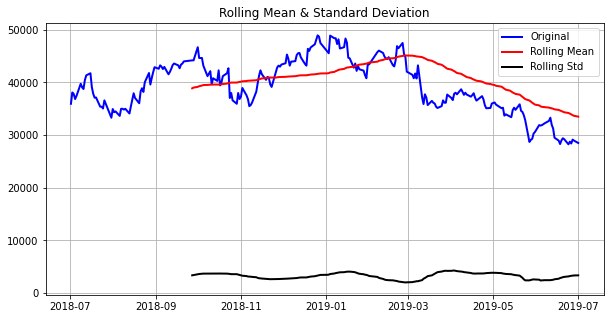

ADF Statistic: -1.1859293191590858
p-value: 0.679619087484661
Critical Values:
	1%: -3.4575505077947746
	5%: -2.8735087323013526
	10%: -2.573148434859185


In [19]:
get_stationarity(train,60) # p-value : 0.60.. > 0.05 => Non-Stationary

In [21]:
train_diff=train.diff()
train_diff=train_diff.dropna()                # 종가를 1차차분한 값들 -> train_diff 

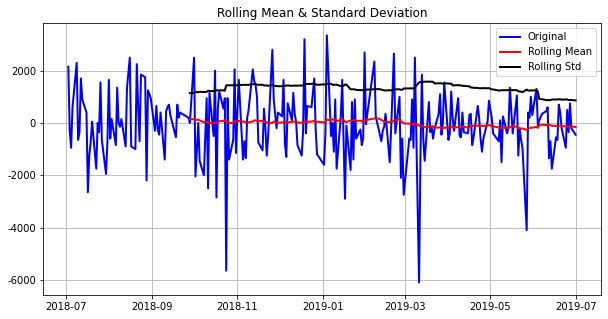

ADF Statistic: -17.20699429927333
p-value: 6.405149576186949e-30
Critical Values:
	1%: -3.4575505077947746
	5%: -2.8735087323013526
	10%: -2.573148434859185


In [22]:
get_stationarity(train_diff,60) # p-value : 0.00.. < 0.05  / 이동평균선과 이동표준편차가 x축과 평행 => Stationary (p,d,q중, d = 1 / s=60)

<function matplotlib.pyplot.show>

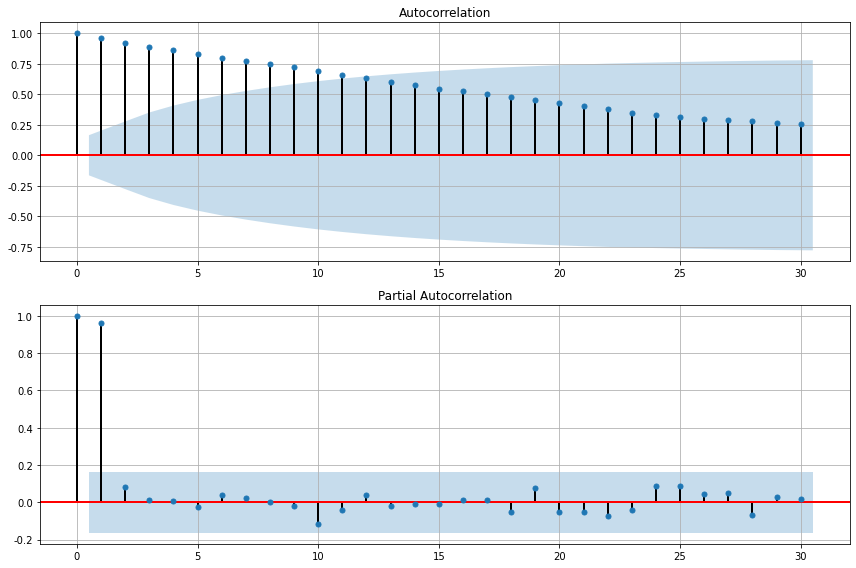

In [23]:
# ACF그래프 (자기상관함수) : 
#자기상관은 시점 t 와 (t - n) 간의 상관 관계를 의미하며 한동안(일정 기간) 증가하거나 감소하는 경우 양의 자기상관이 존재한다고 하고 시점마다 증감이 반복되는 경우 이를 음의 자기상관이라 한다

# PACF그래프 (부분자기상관함수) : 
# 부분자기상관은 시점 (t-1) ~ (t-n+1)의 영향을 배제한, 시점 t와 (t - n)과의 상관관계를 의미한다.   

# ACF, PACF그래프의 x축은 lag,지연값,시점 (t-n)에서 n의 값이다.

# train 원데이터의 ACF, PACF그래프 그리기
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train, lags=30, ax=ax1, alpha=0.01)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train,lags=30,ax=ax2,alpha=0.01)
plt.tight_layout()
plt.show


# => Random Walk (Non-Stationary)의 특징을 보임 (Acf그래프에서는 천천히 감소, Pacf에서는 급격하게 감소(lag=1에서 절단점 발생))

<function matplotlib.pyplot.show>

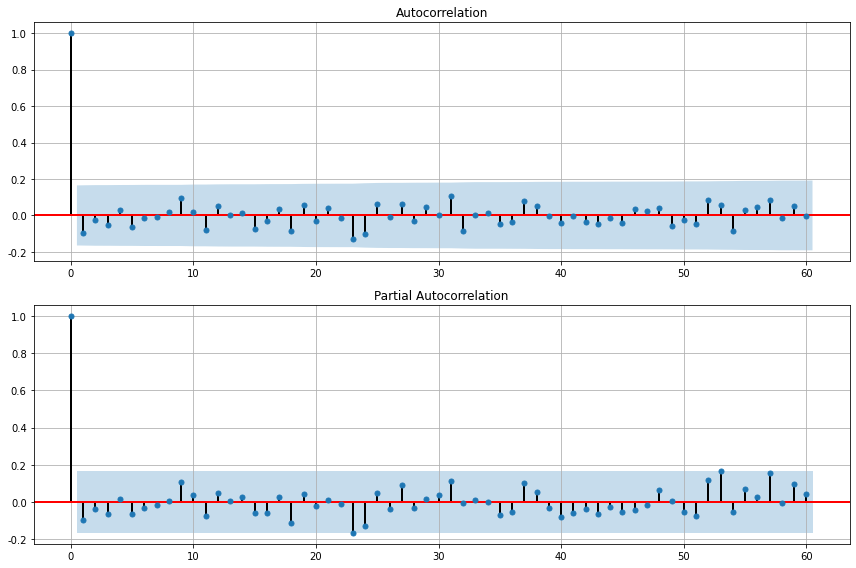

In [24]:
# train데이터를 1차차분한 값의 ACF,PACF그래프 그리기
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_diff, lags=60, ax=ax1, alpha=0.01)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_diff,lags=60,ax=ax2,alpha=0.01)
plt.tight_layout()
plt.show

# => White noise(Stationary)데이터의 acf,pacf그래프 양상을 보임 , ARIMA(p,d,q)에서 p=0, q=0 


# 따라서, 1차차분한 값의 p=0,q=0이라고 판단됨 => (p,d,q) = (0,1,0)

In [25]:
# 그래프등을 통해 판단된 값으로 ARIMA모델실행, Fitting
'''
#from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX
#model = SARIMAX(train, order=(0,1,0),seasonal_order=(0,1,1,60))
#model_fit = model.fit(trend='c',full_output=True, disp=1) 
#print(model_fit.summary()) 

#  P > |z| 값이 일반적으로 학습의 적정성을 위해 확인되는 t-test값

#model_fit.plot_diagnostics()
#plt.tight_layout()
#plt.show()


forecast_test1 = model_fit.get_prediction(period=43)
#forecast_test1=pd.DataFrame(forecast_test1)
pred1 = forecast_test1.conf_int(alpha=0.05)
pred1_mean=forecast_test1.predicted_mean
#print(forecast_test1)
pred1_mean.plot()
'''

"\n#from statsmodels.tsa.arima_model import ARIMA\n#from statsmodels.tsa.statespace.sarimax import SARIMAX\n#model = SARIMAX(train, order=(0,1,0),seasonal_order=(0,1,1,60))\n#model_fit = model.fit(trend='c',full_output=True, disp=1) \n#print(model_fit.summary()) \n\n#  P > |z| 값이 일반적으로 학습의 적정성을 위해 확인되는 t-test값\n\n#model_fit.plot_diagnostics()\n#plt.tight_layout()\n#plt.show()\n\n\nforecast_test1 = model_fit.get_prediction(period=43)\n#forecast_test1=pd.DataFrame(forecast_test1)\npred1 = forecast_test1.conf_int(alpha=0.05)\npred1_mean=forecast_test1.predicted_mean\n#print(forecast_test1)\npred1_mean.plot()\n"

In [ ]:
# Auto_Arima모델 

In [26]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 3.0MB/s 
     |████████████████████████████████| 808kB 16.5MB/s 
     |████████████████████████████████| 2.1MB 16.5MB/s 
     |████████████████████████████████| 8.7MB 25.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 50.3.0
    Uninstalling setuptools-50.3.0:
      Successfully uninstalled setuptools-50.3.0
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [34]:
train

,y
날짜,
2018-07-02,35950
2018-07-03,38100
2018-07-04,37800
2018-07-05,36850
2018-07-06,37450
...,...
2019-06-25,28750
2019-06-26,28400
2019-06-27,29150


In [32]:
from pmdarima import auto_arima
stepwise_model = auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=60,
                           seasonal=True,
                           d=1, D=1, trace=True,
                           error_action=
                            'ignore',  
                           suppress_warnings=True,
                           stepwise=True)


# AIC값이 최소값이 나오는 파라미터를 선정한다.
# AIC는 Akaike Information Criterion이다. AIC는 얼마나 모델이 데이터를 잘 피팅하는지를 측정함. 
# AIC(Akaike Information Criterion) value
# The AIC measures how well a model fits the data while taking into account the overall complexity of the model.
# A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit.


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[60]             : AIC=inf, Time=86.01 sec
 ARIMA(0,1,0)(0,1,0)[60]             : AIC=3304.350, Time=1.75 sec
 ARIMA(1,1,0)(1,1,0)[60]             : AIC=3265.434, Time=25.00 sec
 ARIMA(0,1,1)(0,1,1)[60]             : AIC=3252.857, Time=32.51 sec
 ARIMA(0,1,1)(0,1,0)[60]             : AIC=3303.620, Time=1.46 sec
 ARIMA(0,1,1)(1,1,1)[60]             : AIC=inf, Time=42.14 sec
 ARIMA(0,1,1)(0,1,2)[60]             : AIC=inf, Time=nan sec
 ARIMA(0,1,1)(1,1,0)[60]             : AIC=3271.713, Time=9.57 sec
 ARIMA(0,1,1)(1,1,2)[60]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,1,1)[60]             : AIC=inf, Time=24.19 sec
 ARIMA(1,1,1)(0,1,1)[60]             : AIC=3253.235, Time=69.65 sec
 ARIMA(0,1,2)(0,1,1)[60]             : AIC=3253.592, Time=37.56 sec
 ARIMA(1,1,0)(0,1,1)[60]             : AIC=3252.684, Time=30.75 sec
 ARIMA(1,1,0)(0,1,0)[60]             : AIC=3303.258, Time=0.95 sec
 ARIMA(1,1,0)(1,1,1)[60]             :

In [ ]:
# 잡음(불규칙요인)의 분포 살피기 (표준잔차, 잔차분포, Normal Q-Q (QQ-Plot), 상관성)

# https://data.library.virginia.edu/diagnostic-plots/ 참고
#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3 참고

# 표준잔차 : 추정 회귀식으로부터 관측치가 얼마나 떨어져 있는지, 절댓값 3이상이면 이상값이 확실, 연구자에 따라 2~3사이의 값을 이상값일 가능성이 달라짐.
# 잔차분포 : 
# QQ-plot : 수집 데이터를 표준정규분포의 분위수와 비교하여 그리는 그래프 -> 데이터의 정규성 가정에 대한 검토를 가능하게 해줌 -> 집단이 정규성을 따른다면, 점들이 직선의 형태로 그려짐.
# 상관성 : correlation확인

result_seasonal=stepwise_model.fit(train)
result_seasonal.plot_diagnostics(figsize=(12,10))          
plt.show()                                                

In [ ]:
result=pd.DataFrame() # 예측한 10개월을 concat해서  한번에 볼 데이터프레임

In [ ]:
'''
test1 = df['2019-07-02':'2019-08-30']            
test2 = df['2019-09-02':'2019-10-31']          
test3 = df['2019-11-01':'2019-12-31']          
test4 = df['2020-01-02':'2020-02-29']           
test5 = df['2020-03-02':'2020-04-30']
  
test_all=df['2019-07-02':'2020-04-30'] 


test1['날짜']=test1.index
test1_n=pd.DataFrame({'y':test1['종가']})
#test=test.reset_index(drop=True)

test2['날짜']=test2.index
test2_n=pd.DataFrame({'y':test2['종가']})
#test=test.reset_index(drop=True)

test3['날짜']=test3.index
test3_n=pd.DataFrame({'y':test3['종가']})
#test=test.reset_index(drop=True)

test4['날짜']=test4.index
test4_n=pd.DataFrame({'y':test4['종가']})
#test=test.reset_index(drop=True)

test5['날짜']=test5.index
test5_n=pd.DataFrame({'y':test5['종가']})
#test=test.reset_index(drop=True)

test_all['날짜']=test_all.index
test_all_n=pd.DataFrame({'y':test_all['종가']})
#test=test.reset_index(drop=True)

print(train.shape) # 245 x x2 
print(test1.shape) # 43 x 8 (약 두달) 
print(test2.shape) # 40 x 6
print(test3.shape) # 41 x 6
print(test4.shape) # 40 x 6
print(test5.shape) # 42 x 6
print(test_all.shape) # 42 x 6

print(test1.columns) # -> 종가만
'''

In [33]:
# 10개월 예측 : 
# model에 train을 fit -> predict(2달) -> predict값을 train에 concat(합침) -> 다시 model에 train을 fit -> ... (반복)   

start_date=['2019-07-02','2019-09-02','2019-11-01','2020-01-02','2020-03-02']
end_date=['2019-08-30','2019-10-31','2019-12-31','2020-02-29','2020-04-30']

test_all=df[start_date[0]:end_date[-1]]

for i in range(0,5):
  test=df[start_date[i]:end_date[i]]
  print(test)
  '''
  result_seasonal=stepwise_model.fit(train)

  pred_seasonal = result_seasonal.predict(n_periods=test.shape[0])
  pred_seasonal = pd.DataFrame(pred_seasonal,index = test1.index,columns=['y'])
  pred_seasonal['y']=round(pred_seasonal['y'])

  train=pd.concat([train,pred_seasonal],axis=0)
  '''

와이지엔터테인먼트      시가     고가     저가     종가     거래량
날짜                                            
2019-07-02  28250  29800  28200  29000  384554
2019-07-03  29300  29300  28350  28550  264976
2019-07-04  28550  29150  28500  28850  131863
2019-07-05  29000  29200  28600  29050  126249
2019-07-08  28800  29300  27600  27950  260711
2019-07-09  27850  28700  27700  27700  184764
2019-07-10  27750  29150  27750  28600  287805
2019-07-11  28600  29850  28600  29850  290271
2019-07-12  29500  29800  28350  28500  397232
2019-07-15  28800  28800  28000  28150  188563
2019-07-16  28150  28400  27900  28250  147086
2019-07-17  28100  28150  27450  27550  166749
2019-07-18  26950  27450  25750  27000  462908
2019-07-19  27000  28300  27000  27800  216773
2019-07-22  28000  28000  27200  27750   82836
2019-07-23  27750  28200  27300  27350  137128
2019-07-24  27350  27700  27150  27150  125235
2019-07-25  26900  27100  26350  26550  136106
2019-07-26  26000  26500  25150  25250  326307
2019-07-29  2

In [35]:
# 10개월 예측 : 
# model에 train을 fit -> predict(2달) -> predict값을 train에 concat(합침) -> 다시 model에 train을 fit -> ... (반복)   

start_date=['2019-07-02','2019-09-02','2019-11-01','2020-01-02','2020-03-02']
end_date=['2019-08-30','2019-10-31','2019-12-31','2020-02-29','2020-04-30']

test_all=df[start_date[0]:end_date[-1]]

for i in range(0,5):
  test=df[start_date[i]:end_date[i]]
  
  result_seasonal=stepwise_model.fit(train)

  pred_seasonal = result_seasonal.predict(n_periods=test.shape[0])
  print(pred_seasonal)
  pred_seasonal = pd.DataFrame(pred_seasonal,index = test.index,columns=['y'])
  pred_seasonal['y']=round(pred_seasonal['y'])

  train=pd.concat([train,pred_seasonal],axis=0)

[29129.8689468  28652.45087847 28450.19993245 27956.37513961
 27650.37042486 27429.5471795  26418.86025573 26335.03898519
 26111.43987551 25341.18038359 24608.1116305  22813.75651288
 23151.80555708 22548.36409346 22062.41533065 21219.33254037
 20366.48523305 20098.26022312 20254.43696929 20575.48631688
 19920.35485903 19829.67651678 19690.09332048 18632.3087175
 18593.85023205 18193.39840299 18123.72139698 18937.02336612
 18309.5712506  17541.52600663 18342.38531588 18168.61370781
 17456.83301468 17208.90577434 16479.03319222 14013.9698856
 13380.89420018 13111.67361773 13284.91379145 13389.21202972
 13779.08304989 13954.40306845 11947.26753144]
[11649.6564902  11903.0022419  11953.25086831 10825.43693306
 10518.65972151  9277.1435271   8481.24551479  7654.87799664
  8181.93641196  8123.13661997  8173.48412711  7450.06302882
  8966.21929569  9218.60163068  8711.85885834  7937.63249393
  7599.37445243  8068.13452964  7459.48167093  7068.43793767
  6473.77447126  6045.83187025  5695.604

In [39]:
pred=train[start_date[0]:]
pred

,y
날짜,
2019-07-02,29130.0
2019-07-03,28652.0
2019-07-04,28450.0
2019-07-05,27956.0
2019-07-08,27650.0
...,...
2020-04-23,-77728.0
2020-04-24,-78308.0
2020-04-27,-79679.0


In [40]:
test_all


와이지엔터테인먼트,시가,고가,저가,종가,거래량
날짜,,,,,
2019-07-02,28250,29800,28200,29000,384554
2019-07-03,29300,29300,28350,28550,264976
2019-07-04,28550,29150,28500,28850,131863
2019-07-05,29000,29200,28600,29050,126249
2019-07-08,28800,29300,27600,27950,260711
...,...,...,...,...,...
2020-04-23,29300,29450,28800,29150,138419
2020-04-24,28900,28900,27750,28050,206180
2020-04-27,28350,29100,28000,28850,194223


<function matplotlib.pyplot.show>

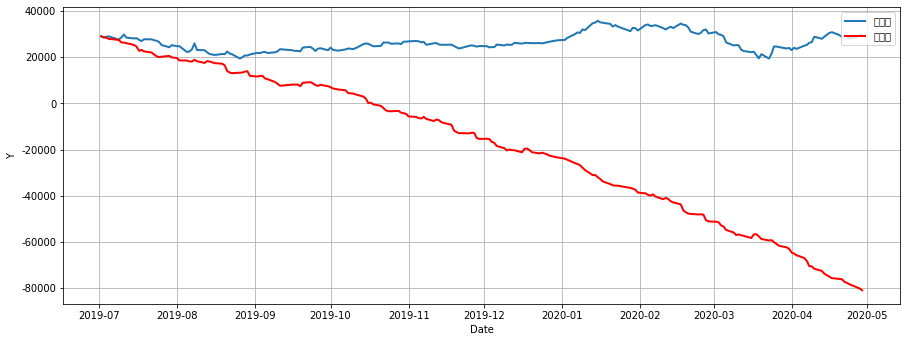

In [41]:
# 10개월 예측값(pred)과 실제값(test_all)을 그래프로 비교 및 mape확인
pred=train[start_date[0]:]

fm._rebuild()
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(211)
ax1.plot(test_all['종가'],label='실제값' )                 ##
ax1.plot(pred['y'],color='red',label='예측값')    ## 
ax1.set_xlabel('Date')
ax1.set_ylabel('Y')
ax1.legend(loc=1)
plt.show

# Compute the Mean of Absolute Percentage Errors

#mape = ((abs( pred['y'] - test_all['종가'] ) / test_all['종가'])*100).mean()
#print('The MAPE of our forecasts is {}%'.format( round(mape, 2))) 